# 환경설정

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# 본인의 드라이브 경로를 복사해서 경로를 변경해준다.
%cd /content/drive/MyDrive/KHUDA

/content/drive/MyDrive/KHUDA


In [37]:
# 현재 경로 출력
!pwd

/content/drive/MyDrive/KHUDA


In [38]:
# 현재 경로에 어떤 파일들이 있는지 출력
!ls

 cbow_predict.py   common    KHUDA_과제1.ipynb	     __pycache__
'Chapter 2.pdf'    dataset   KHUDA_CBOW_code.ipynb   simple_cbow.py
'Chapter 3.pdf'    images    자연어처리란.pdf


In [39]:
# 경로 추가
import sys
sys.path.append('/content/drive/MyDrive/KHUDA')
print(sys.path)

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/KHUDA', '..', '..', '..', '..', '..', '..', '..', '..', '..', '..', '..', '..', '..', '/content/drive/MyDrive/KHUDA']


# Chap03 - Word2Vec

## 3.2 단순한 Word2Vec

### 3.2.1 CBOW 모델의 추론 처리

**CBOW**(Continuous Bag-Of-Words) 모델은 맥락(context, 주변 단어)로부터 타깃(target, 중심 단어)을 추측하는 신경망이다. 

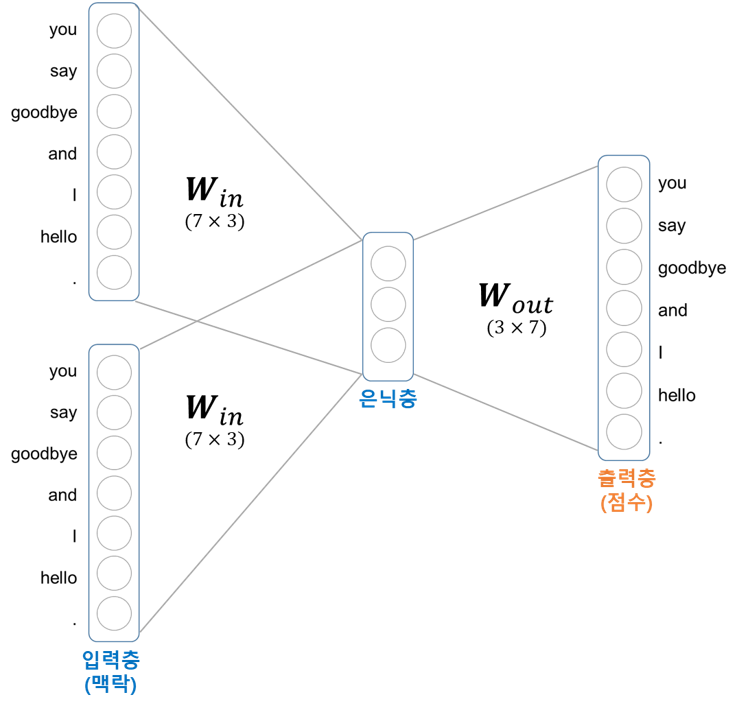

In [40]:
from PIL import Image
from IPython.display import Image

image1 = Image(filename='images/cbow.png')
display(image1)

- 모델의 입력은 맥락(context) 즉, 주변 단어다.

- 은닉층의 뉴런은 입력층의 완전연결계층에 의해 변환된 값이 되는데, CBOW에서는 `wiindow_size * 2`($C$) 개수 만큼 입력이 되므로 전체의 **평균**(average)을 해준다.  


$$
\mathbf{h} = \frac{1}{C} (h_1 + \cdots h_c)
$$


- 출력층의 뉴런은 해당 단어의 개수(`vocab_size`)와 같고, 뉴런 하나하나가 각 단어에 대응한다. 출력층 뉴런은 각 단어의 **'점수'**(score, softmax를 지나기전 상태)를 뜻하며, 값이 높을 수록 대응 단어의 출현 확률도 높아진다.

- 위의 그림에서 $\mathbf{W}_{\text{in}}$의 각 행(row)과 $\mathbf{W}_{\text{out}}$의 각 열(column)이 바로 단어의 분산 표현이 된다. $\mathbf{W}_{\text{in}}$와 $\mathbf{W}_{\text{out}}$ 중 어느것을 써도 상관 없지만 보통 $\mathbf{W}_{\text{in}}$을 사용한다.

In [41]:
# CBOW모델의 추론 처리 구현
# chap03/cbow_predict.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)  # average
s = out_layer.forward(h)  # score

print(s)

[[-0.34327604  1.60247825 -0.86489623  1.56113346  0.0087953  -1.01473096
  -0.23555257]]


### 3.2.2 CBOW 모델의 학습

CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정한다. 그 결과 가중치 $\mathbf{W}_{\text{in}}$와 $\mathbf{W}_{\text{out}}$에 각 단어의 벡터가 학습된다.

Word2Vec 모델은 단어 출현 패턴을 학습할 때 사용한 말뭉치(corpus)로부터 학습한다. 그렇기 때문에 말뭉치가 다르면 학습 후 얻게 되는 단어의 분산 표현도 달라진다.

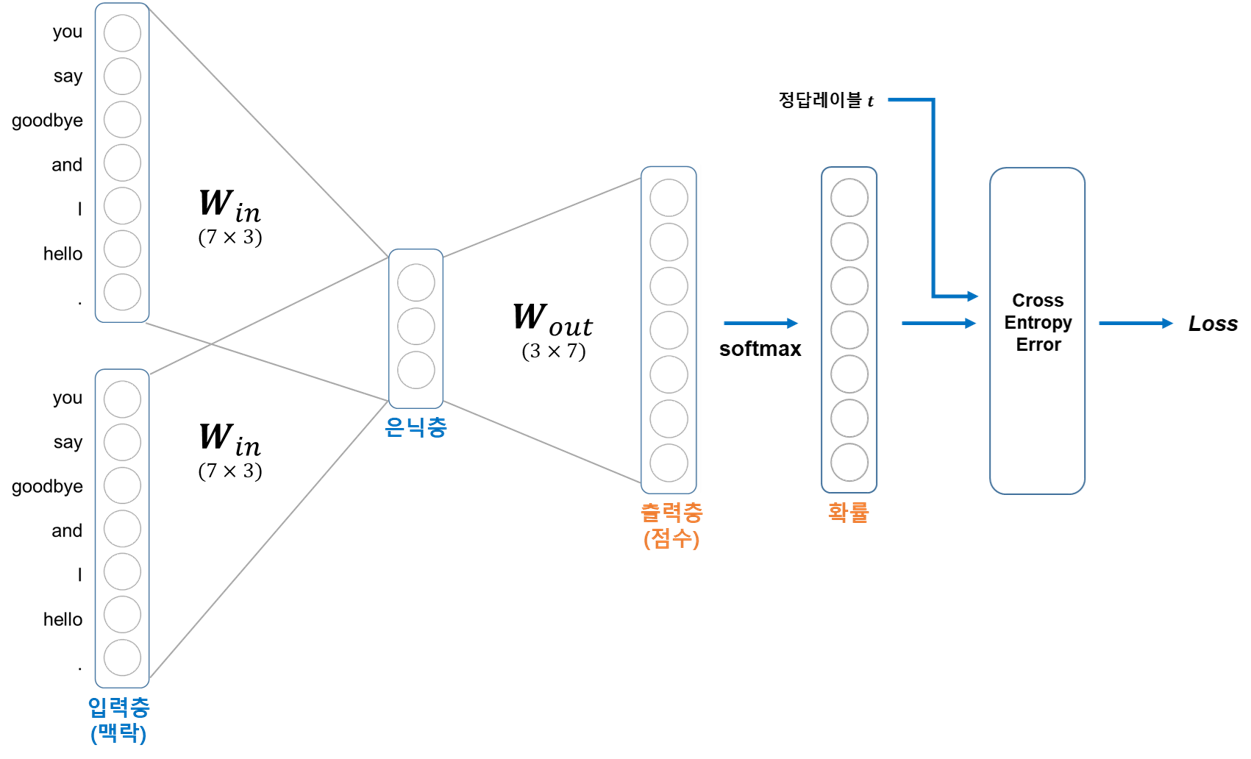

In [42]:
from PIL import Image
from IPython.display import Image

image2 = Image(filename='images/cbow02.png')
display(image2)

## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃

Word2Vec, 특히 CBOW에서 이용하는 신경망의 입력은 맥락(context, 주변단어)이고, 정답 레이블은 맥락에 둘러싸인 중앙(center) 단어이다. 신경망에 '맥락'을 입력했을 때 '타깃'이 출현할 확률을 높이는 것이다. CBOW 모델에서 입력 데이터인 맥락은 여러 개(`window_size * 2`)가 될 수 있지만 타깃은 오직 하나 뿐이다.

![](./images/train_set.png)

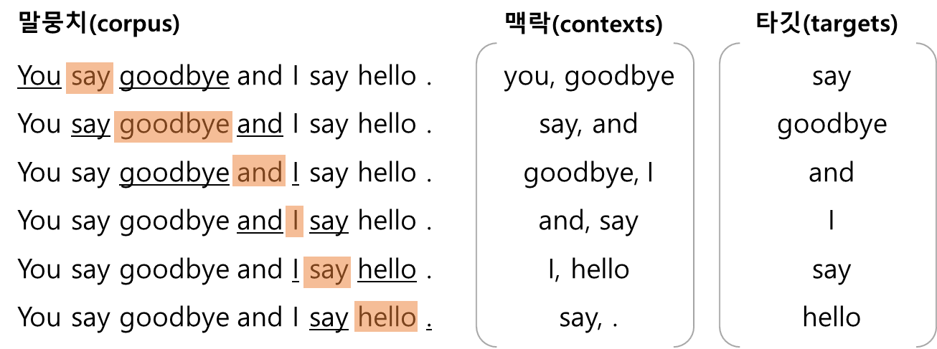

In [43]:
from PIL import Image
from IPython.display import Image

image3 = Image(filename='images/train_set.png')
display(image3)

과정 1) text데이터를 말뭉치(corpus)로 생성

In [44]:
import sys
sys.path.append('..')
from common.util import preprocess

# 실습
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [45]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


과정 2) 신경망의 입력으로 맥락(contexts)과 타깃(target)이 필요하여, 말뭉치(corpus)를 통해 만들어준다.

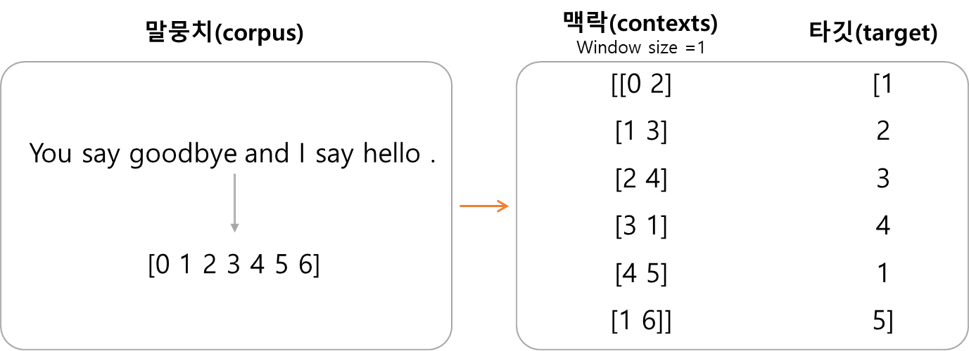

In [46]:
from PIL import Image
from IPython.display import Image

image2 = Image(filename='images/train_set2.png')
display(image2)

In [47]:
# common/util.py
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: (맥락, 타겟)의 np.array
    '''
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # wiondow_size만큼 타겟 단어 좌우 context 가져오기
        for t in range(-window_size, window_size+1):
            if t != 0:
                cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [48]:
import sys
sys.path.append('..')
from common.util import create_contexts_target

contexts, target = create_contexts_target(corpus, window_size=1)

In [49]:
print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [50]:
print(target)

[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

![](./images/one-hot2.png)

과정 3) 학습을 위해 각 맥락과 타겟을 위치 정보(1)를 가진 고정 길이 벡터로 변환해준다.

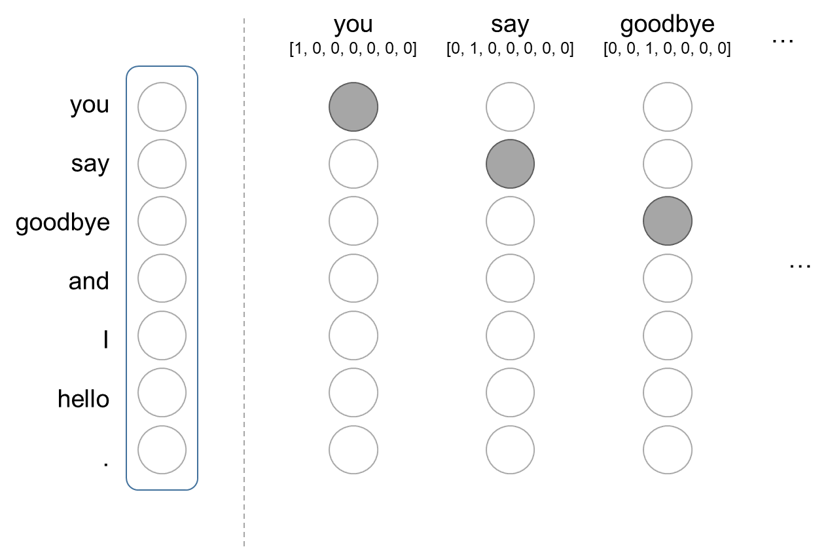

In [51]:
from PIL import Image
from IPython.display import Image

image2 = Image(filename='images/one-hot.png')
display(image2)

In [52]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
            
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
                
    return one_hot

In [53]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodby and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [54]:
print(target)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [55]:
print(contexts)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## 3.4 CBOW 모델 구현

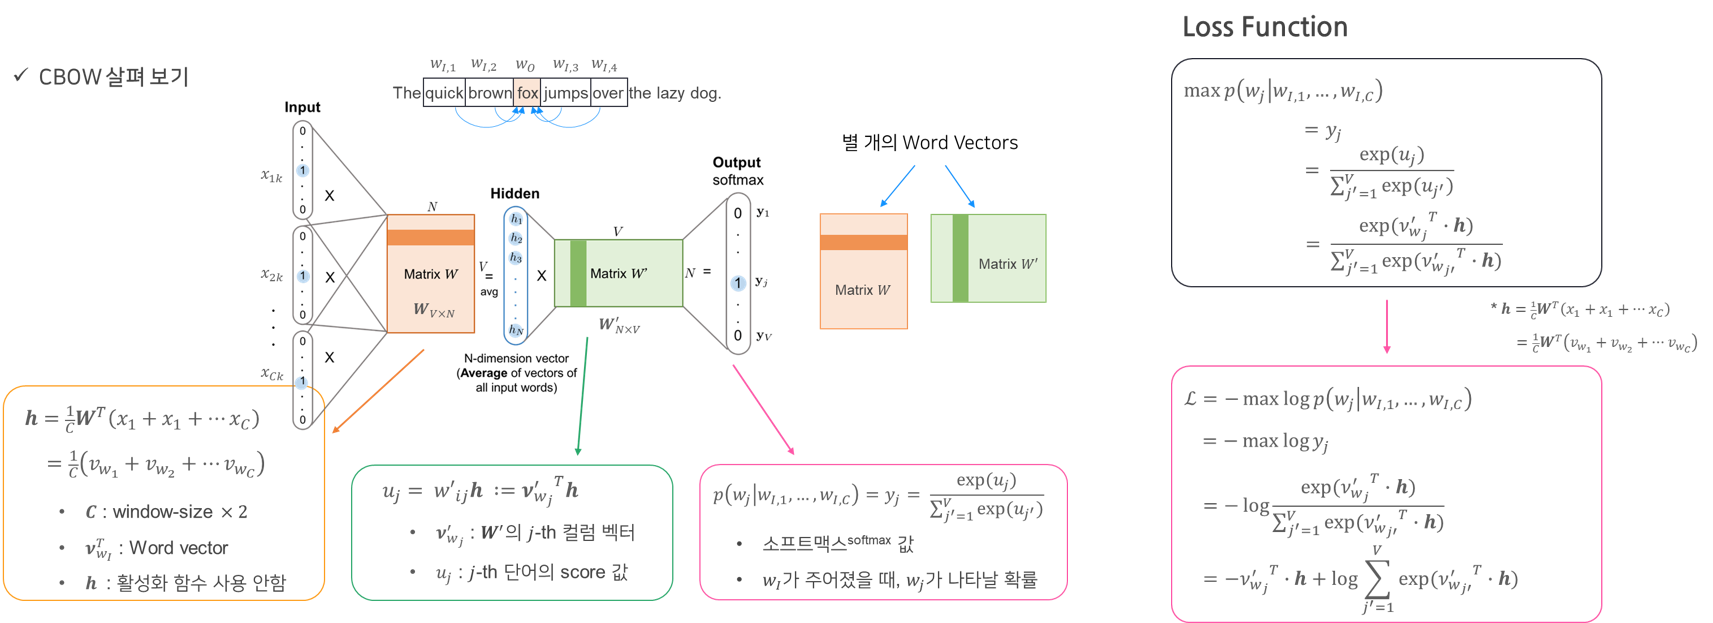

In [56]:
from PIL import Image
from IPython.display import Image

image2 = Image(filename='images/cbow03.png')
display(image2)

In [57]:
# chap03/simple_cbow.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        print("layers:", layers)
        self.params, self.grads = [], []
        for layer in layers:
            print("layer:", layer)
            self.params += layers.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 3.4.1 학습 코드 구현

In [58]:
# chap03/train.py
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
# cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)
# Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [59]:
# 학습
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

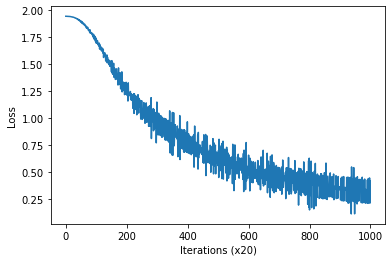

In [60]:
trainer.plot()

Word Embedding : 단어를 벡터로 변환해주는 것으로, 단어마다 고유한 위치정보(분산표현)를 부여하여, 단어 사이의 유사도 등을 계산할 때 사용되는 기법이다.

In [61]:
# Word Embedding 살펴보기
word_vecs1 = model.word_vecs1
for word_id, word in id_to_word.items():
    print(word, word_vecs1[word_id])

you [ 0.99338734  1.6602079   0.907201    1.0019686  -0.9515328 ]
say [-1.1703736   1.2109146  -0.36103806 -1.1642085   1.1725305 ]
goodbye [ 1.012772   -0.62622267  1.0231172   1.0042614  -1.0538027 ]
and [-0.7473082   1.1962557  -1.8855214  -0.6396874   0.66366845]
i [ 0.9935369 -0.6165837  1.0314498  1.0056243 -1.0214286]
hello [ 0.99435717  1.6590345   0.900407    0.9801967  -0.9600514 ]
. [-1.1680254   0.71623725  1.7975769  -1.19347     1.2716293 ]


In [62]:
# Word Embedding 살펴보기
word_vecs2 = model.word_vecs2
for word_id, word in id_to_word.items():
    print(word, word_vecs2[word_id])

you [ 0.04659894 -1.4378322  -0.75407684 -0.07309917  0.1225149 ]
say [ 0.916154    1.785964    0.79297745  0.9039941  -0.8639553 ]
goodbye [-0.57995725  0.4137733  -1.2053728  -0.57041276  0.58199495]
and [ 0.74385935 -2.2837598   0.69387114  0.7276312  -0.7448773 ]
i [-0.5641537   0.4196032  -1.2130738  -0.5819893   0.57309675]
hello [-0.85791534  0.31182358  1.5666977  -0.9173756   0.9169451 ]
. [ 0.03115661 -1.430789   -0.75051284 -0.07685219  0.10193082]


### t-SNE를 이용한 2차원 공간상의 매핑

In [63]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(word_vecs2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [64]:
vocab = list(id_to_word.values())

In [65]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.shape

(7, 2)

In [66]:
df.head()

,x,y
you,-16.634228,-40.618538
say,83.141586,-74.699051
goodbye,62.769657,28.750648
and,43.092480,-28.855368
i,102.819199,-17.092697


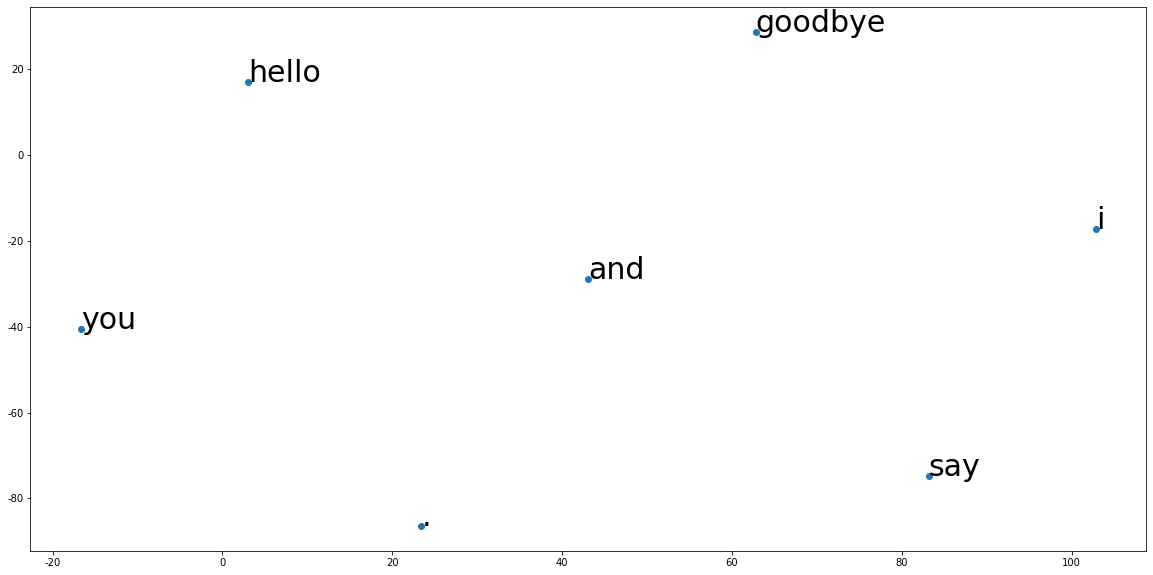

In [67]:
fig = plt.figure()
fig.set_size_inches(20, 10)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()